In [448]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import csv
import os.path
from __future__ import print_function
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

## load data and build vocabulary

In [28]:
def load_data(filename):
    left = []
    right = []
    labels = []
    labels_dict = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    with open(filename, ) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        next(reader)
        for line in reader:
            s1, s2, label = line
            left.append(s1)
            right.append(s2)
            labels.append(label)
    print('the maximum length for premise is:{}'.format(max(len(x.split()) for x in left)))
    print('the maximum length for hypothesis is:{}'.format(max(len(x.split()) for x in right)))
    Y = np.array([labels_dict[l] for l in labels]) 
    return left, right, Y

In [326]:
training = load_data('hw2_data/snli_train.tsv')
validation = load_data('hw2_data/snli_val.tsv')
MAX_LEN_1 = 70
MAX_LEN_2 = 50

the maximum length for premise is:82
the maximum length for hypothesis is:41
the maximum length for premise is:53
the maximum length for hypothesis is:26


In [ ]:
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [ ]:
raw_embedding = load_embedding('wiki-news-300d-1M.vec')

In [63]:
def build_vocab(data):
    all_tokens = []
    for sentence in data:
        all_tokens += sentence.split()
    unique_tokens = list(set(all_tokens))
    unique_tokens = [unique_token for unique_token in unique_tokens if unique_token in raw_embedding.keys()]
    id2token = unique_tokens
    token2id = dict(zip(unique_tokens, range(2,2+len(unique_tokens))))
    id2token = ['<pad>', '<unk>'] + id2token  
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token


In [64]:
token2id, id2token = build_vocab(training[0] + training[1])
print('the vocabulary size of training set is:{}' .format(len(id2token)))

the vocabulary size of training set is:22059


In [65]:
VOCAB = len(id2token)

## build embedding matrix

In [90]:
embedding_matrix = np.zeros((VOCAB, 300))
for word, i in token2id.items():
    embbeding_vector = raw_embedding.get(word)
    if embbeding_vector is not None:
        embedding_matrix[i] = embbeding_vector
    # initialize unknown words embedding randomly
    elif word == '<unk>':
        embedding_matrix[i] = np.random.normal(0, 1, 300)
    # initialize padding as zero vectors
    else:
        embedding_matrix[i] = np.zeros(300)

In [95]:
embedding_matrix.shape

(22059, 300)

In [70]:
training[0]

['A young girl in a pink shirt sitting on a dock viewing a body of water .',
 'A woman is smiling while the man next to her is focused on a blue object with a pattern on it .',
 'Across the river , you can see a large building .',
 'a man in white shorts and a black shirt is paragliding on the ocean',
 'Four black dogs run together on bright green grass .',
 'A female laying on her stomach in the water outside with umbrellas .',
 'Children eat at a long table with black chairs .',
 'A person rides a motorcycle quickly .',
 'Woman riding a red bicycle down a city street , with a few people in the background .',
 "Two young women dancers , one brunette and one blond , wearing similar red and black costumes and occupying a similarly colored `` dance cage '' , entertain a gathering crowd .",
 'The black dog is jumping over the white pole in the grass .',
 'Two young adults are setting up the video camera for some action .',
 'A young boy in a Sesame Street bib sits in his highchair and ope

## convert token to id in the dataset

In [75]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for sentence in tokens_data:
        tokens = sentence.split()
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)        
    return indices_data

train_data_indices = token2index_dataset(training[0]), token2index_dataset(training[1])
val_data_indices = token2index_dataset(validation[0]), token2index_dataset(validation[1])

# double checking
print ("Train dataset size is {}".format(len(train_data_indices[0])))
print ("Val dataset size is {}".format(len(val_data_indices[0])))


Train dataset size is 100000
Val dataset size is 1000


In [327]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list_0 = data_list[0]
        self.data_list_1 = data_list[1]
        self.target_list = target_list
        assert (len(self.data_list_0) == len(self.target_list))
        assert (len(self.data_list_1) == len(self.target_list))

    def __len__(self):
        return len(self.data_list_0)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx_0 = self.data_list_0[key][:MAX_LEN_1]
        token_idx_1 = self.data_list_1[key][:MAX_LEN_2]
        label = self.target_list[key]
        return [token_idx_0, len(token_idx_0), token_idx_1, len(token_idx_1), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_0 = []
    data_list_1 = []
    label_list = []
    length_list_0 = []
    length_list_1 = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        length_list_0.append(datum[1])
        length_list_1.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_0 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_LEN_1-datum[1])), 
                                mode="constant", constant_values=0)
        data_list_0.append(padded_vec_0)
        padded_vec_1 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_LEN_2-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
    return [torch.from_numpy(np.array(data_list_0)), torch.LongTensor(length_list_0), 
            torch.from_numpy(np.array(data_list_1)), torch.LongTensor(length_list_1), torch.LongTensor(label_list)]

In [445]:
train_dataset = NewsGroupDataset(train_data_indices, training[2])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, validation[2])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


In [557]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, hidden_size_fc, kernel_size=3, dropout=0, interact_method='concat'):
        super(CNN, self).__init__()

        self.hidden_size =  hidden_size
        self.drop = nn.Dropout(dropout)
        #we want to update parameters for unknown words artificially
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix), freeze=True)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding = 1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.interact_method = interact_method
        if self.interact_method == 'concat':
            input_hidden_size = hidden_size*2
        else:
            input_hidden_size = hidden_size
        self.fc = nn.Sequential(nn.Linear(input_hidden_size, hidden_size_fc), nn.ReLU(inplace=True), nn.Linear(hidden_size_fc,num_classes))

    def forward(self, x_0, lengths_0, x_1, lengths_1):
        batch_size_0, seq_len_0 = x_0.size()
        
        embed_0 = self.embedding(x_0).permute(0,2,1)
        sen1_conv1 = F.relu(self.conv1(embed_0))
        sen1_conv2 = F.relu(self.conv2(sen1_conv1)).permute(0,2,1)
        sen1_representation = sen1_conv2.max(dim=1)[0]

        embed_1 = self.embedding(x_1).permute(0,2,1)
        sen2_conv1 = F.relu(self.conv1(embed_1))
        sen2_conv2 = F.relu(self.conv2(sen2_conv1)).permute(0,2,1)
        sen2_representation = sen2_conv2.max(dim=1)[0]
        
        #concat two sentence representation
        if self.interact_method == 'concat':
            combined_vector = torch.cat([sen1_representation, sen2_representation], dim=1)
        elif self.interact_method == 'multiply':
            combined_vector = torch.mul(sen1_representation,sen2_representation)
        elif self.interact_method == 'add':
            combined_vector = sen1_representation + sen2_representation
        
        combined_vector = self.drop(combined_vector)
        output = self.fc(combined_vector)
        
        return output
    

In [489]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_0, lengths_0, data_1, lengths_1, labels in loader:
        data_batch_0, lengths_batch_0, data_batch_1, lengths_batch_1, label_batch = data_0, lengths_0, data_1, lengths_1, labels
        outputs = F.softmax(model(data_batch_0, lengths_batch_0, data_batch_1, lengths_batch_1), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)




In [553]:
def train_model_CNN(emb_size = 300, learning_rate = 0.01, annealing_rate = 0, step = 1, hidden_size=200, hidden_size_fc=200,
                num_epochs = 5, num_classes=3, kernel_size=3, optim = 'Adam', dropout=0,interact_method='concat'):
    """
    Help function that tests the model's performance on a dataset
    @param: emb_dim - embedding size
            vocab_size - vocabulary size
            learning_rate - learning rate of the optimizer, if annealing_rate is not 0, this is a start learning
                rate
            annealing_rate - a factor that shrinks the learning rate every step size
            step - step size (epochs)
            optim - optimizer, can choose from 'Adam' or 'SGD'
            
    """
    model = CNN(emb_size=emb_size, hidden_size=hidden_size, num_classes=num_classes, 
                hidden_size_fc=hidden_size_fc, dropout=dropout, interact_method=interact_method).double()
    criterion = torch.nn.CrossEntropyLoss()  
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # set the scheduler for learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=annealing_rate)
    epoch_train_loss = []
    epoch_val_acc = []
    for epoch in range(num_epochs):
        # only decay the learning rate when annealing rate is given
        if annealing_rate!=0:
            scheduler.step()
        for i, (data_0, lengths_0, data_1, lengths_1, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data_0, lengths_0, data_1, lengths_1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
                
        epoch_train_loss.append(loss.item())
        val_acc = test_model(val_loader, model)
        print('Epoch: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, val_acc))
        epoch_val_acc.append(val_acc)
    return epoch_train_loss, epoch_val_acc, model

In [451]:
plt.rcParams['figure.figsize'] = 10, 8

## Tuning hyperparameters for CNN

### hidden dimension

In [576]:
hidden_sizes = [50, 200, 400]
train_loss_hiddens = []
val_acc_hiddens = []
for hidden_size in hidden_sizes:
    train_loss_hidden, val_acc_hidden, _ = train_model_CNN(emb_size = 300, hidden_size=hidden_size, 
                        hidden_size_fc=hidden_size ,num_classes=3, learning_rate = 0.001, num_epochs = 10)
    train_loss_hiddens.append(train_loss_hidden)
    val_acc_hiddens.append(val_acc_hidden)
        

Epoch: [1/10], Validation Acc: 62.3
Epoch: [2/10], Validation Acc: 64.9
Epoch: [3/10], Validation Acc: 67.7
Epoch: [4/10], Validation Acc: 67.5
Epoch: [5/10], Validation Acc: 68.3
Epoch: [6/10], Validation Acc: 67.8
Epoch: [7/10], Validation Acc: 69.4
Epoch: [8/10], Validation Acc: 68.9
Epoch: [9/10], Validation Acc: 67.8
Epoch: [10/10], Validation Acc: 67.6
Epoch: [1/10], Validation Acc: 65.1
Epoch: [2/10], Validation Acc: 68.1
Epoch: [3/10], Validation Acc: 67.2
Epoch: [4/10], Validation Acc: 68.9
Epoch: [5/10], Validation Acc: 69.2
Epoch: [6/10], Validation Acc: 69.0
Epoch: [7/10], Validation Acc: 69.8
Epoch: [8/10], Validation Acc: 68.9
Epoch: [9/10], Validation Acc: 70.3
Epoch: [10/10], Validation Acc: 68.6
Epoch: [1/10], Validation Acc: 65.6
Epoch: [2/10], Validation Acc: 67.2
Epoch: [3/10], Validation Acc: 69.6
Epoch: [4/10], Validation Acc: 70.7
Epoch: [5/10], Validation Acc: 70.5
Epoch: [6/10], Validation Acc: 70.2
Epoch: [7/10], Validation Acc: 68.7
Epoch: [8/10], Validation 

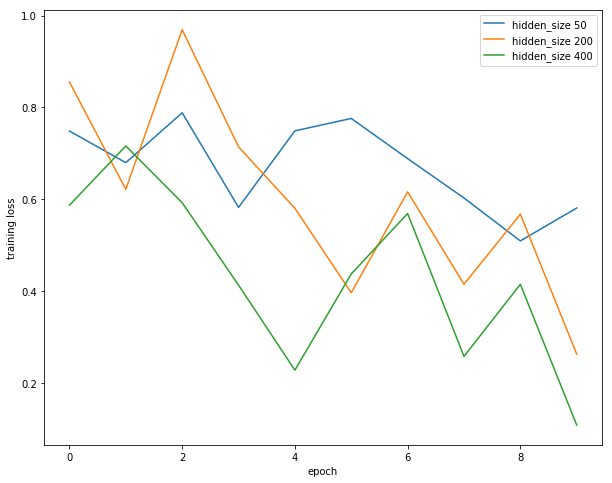

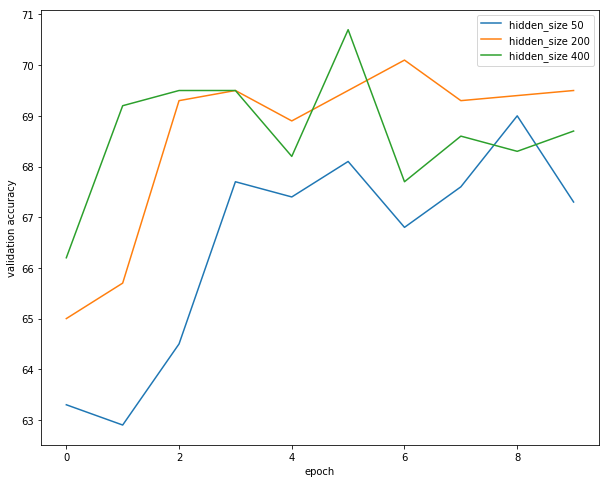

In [462]:
plt.figure()
for i in range(len(train_loss_hiddens)):
    plt.plot(range(10),train_loss_hiddens[i], label='hidden_size %d' %hidden_sizes[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_hiddens)):
    plt.plot(range(10),val_acc_hiddens[i], label='hidden_size %d' %hidden_sizes[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')

### kernel size

In [476]:
kernel_sizes = [3,5,7]
train_loss_kernels = []
val_acc_kernels = []
for kernel_size in kernel_sizes:
    train_loss_kernel, val_acc_kernel, _ = train_model_CNN(emb_size = 300, hidden_size=200, 
                        hidden_size_fc=200 ,num_classes=3, learning_rate = 0.001, num_epochs = 10, kernel_size=kernel_size)
    train_loss_kernels.append(train_loss_kernel)
    val_acc_kernels.append(val_acc_kernel)
            

Epoch: [1/10], Validation Acc: 64.1
Epoch: [2/10], Validation Acc: 67.8
Epoch: [3/10], Validation Acc: 68.9
Epoch: [4/10], Validation Acc: 70.6
Epoch: [5/10], Validation Acc: 70.3
Epoch: [6/10], Validation Acc: 69.6
Epoch: [7/10], Validation Acc: 69.7
Epoch: [8/10], Validation Acc: 69.4
Epoch: [9/10], Validation Acc: 68.5
Epoch: [10/10], Validation Acc: 67.7
Epoch: [1/10], Validation Acc: 64.2
Epoch: [2/10], Validation Acc: 67.4
Epoch: [3/10], Validation Acc: 69.7
Epoch: [4/10], Validation Acc: 69.3
Epoch: [5/10], Validation Acc: 69.0
Epoch: [6/10], Validation Acc: 70.6
Epoch: [7/10], Validation Acc: 70.0
Epoch: [8/10], Validation Acc: 70.5
Epoch: [9/10], Validation Acc: 71.9
Epoch: [10/10], Validation Acc: 70.1
Epoch: [1/10], Validation Acc: 64.8
Epoch: [2/10], Validation Acc: 68.1
Epoch: [3/10], Validation Acc: 69.8
Epoch: [4/10], Validation Acc: 69.9
Epoch: [5/10], Validation Acc: 70.8
Epoch: [6/10], Validation Acc: 70.5
Epoch: [7/10], Validation Acc: 69.7
Epoch: [8/10], Validation 

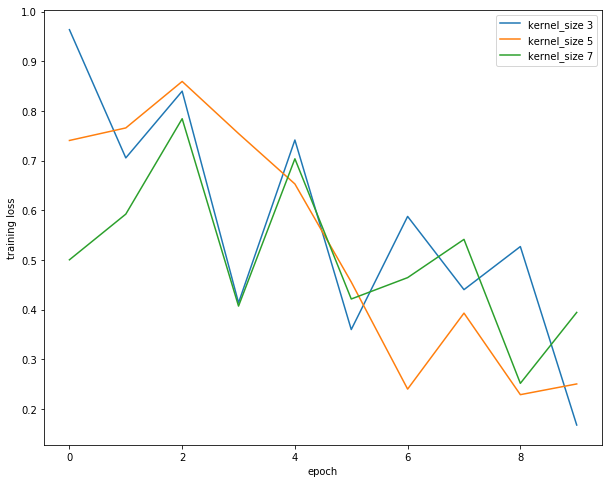

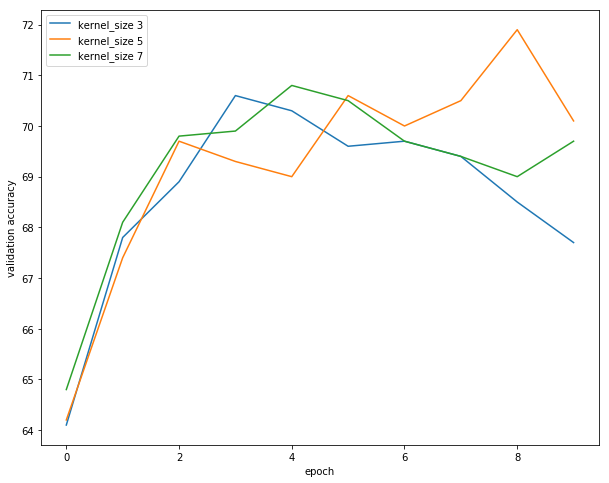

In [477]:
plt.figure()
for i in range(len(train_loss_kernels)):
    plt.plot(range(10),train_loss_kernels[i], label='kernel_size %d' %kernel_sizes[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_kernels)):
    plt.plot(range(10),val_acc_kernels[i], label='kernel_size %d' %kernel_sizes[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')

### drop_out

In [533]:
dropout_rates = [0, 0.4, 0.7]
train_loss_drops = []
val_acc_drops = []
for dropout_rate in dropout_rates:
    train_loss_drop, val_acc_drop, _ = train_model_CNN(emb_size = 300, hidden_size=200, 
                        hidden_size_fc=200 ,num_classes=3, learning_rate = 0.001, num_epochs = 10, 
                                                           kernel_size=5, dropout=dropout_rate)
    train_loss_drops.append(train_loss_drop)
    val_acc_drops.append(val_acc_drop)
            

Epoch: [1/10], Validation Acc: 66.0
Epoch: [2/10], Validation Acc: 67.3
Epoch: [3/10], Validation Acc: 67.9
Epoch: [4/10], Validation Acc: 70.4
Epoch: [5/10], Validation Acc: 70.9
Epoch: [6/10], Validation Acc: 69.8
Epoch: [7/10], Validation Acc: 71.0
Epoch: [8/10], Validation Acc: 70.4
Epoch: [9/10], Validation Acc: 67.5
Epoch: [10/10], Validation Acc: 69.5
Epoch: [1/10], Validation Acc: 65.0
Epoch: [2/10], Validation Acc: 67.1
Epoch: [3/10], Validation Acc: 65.8
Epoch: [4/10], Validation Acc: 67.1
Epoch: [5/10], Validation Acc: 67.4
Epoch: [6/10], Validation Acc: 68.0
Epoch: [7/10], Validation Acc: 68.5
Epoch: [8/10], Validation Acc: 66.2
Epoch: [9/10], Validation Acc: 66.4
Epoch: [10/10], Validation Acc: 68.0
Epoch: [1/10], Validation Acc: 64.2
Epoch: [2/10], Validation Acc: 65.2
Epoch: [3/10], Validation Acc: 65.4
Epoch: [4/10], Validation Acc: 66.3
Epoch: [5/10], Validation Acc: 67.4
Epoch: [6/10], Validation Acc: 68.4
Epoch: [7/10], Validation Acc: 66.7
Epoch: [8/10], Validation 

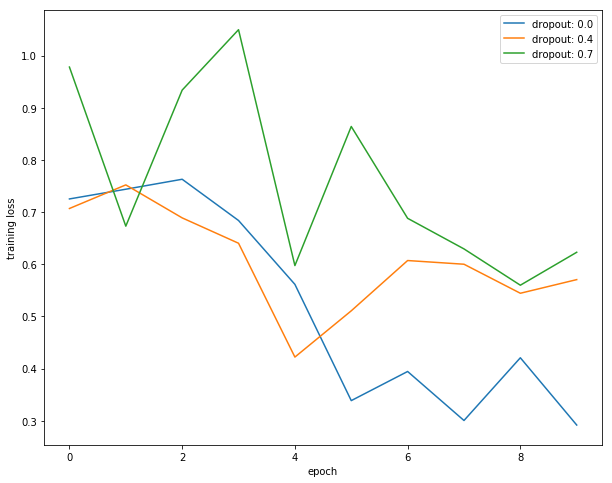

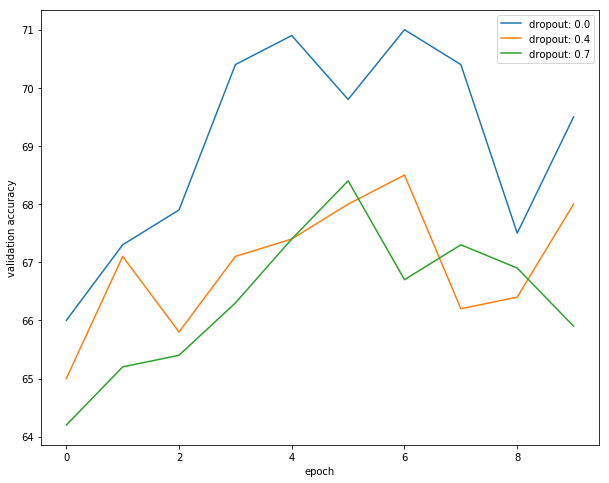

In [536]:
plt.figure()
for i in range(len(train_loss_drops)):
    plt.plot(range(10),train_loss_drops[i], label='dropout: %.1f' %dropout_rates[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_drops)):
    plt.plot(range(10),val_acc_drops[i], label='dropout: %.1f' %dropout_rates[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')

### sentence interaction

In [558]:
interact_methods = ['concat', 'multiply', 'add']
train_loss_methods = []
val_acc_methods = []
for interact_method in interact_methods:
    train_loss_method, val_acc_method, _ = train_model_CNN(emb_size = 300, hidden_size=200, 
                        hidden_size_fc=200 ,num_classes=3, learning_rate = 0.001, num_epochs = 10, 
                                                           kernel_size=5, dropout=0, interact_method = interact_method)
    train_loss_methods.append(train_loss_method)
    val_acc_methods.append(val_acc_method)
    

Epoch: [1/10], Validation Acc: 64.2
Epoch: [2/10], Validation Acc: 67.7
Epoch: [3/10], Validation Acc: 70.2
Epoch: [4/10], Validation Acc: 69.5
Epoch: [5/10], Validation Acc: 69.2
Epoch: [6/10], Validation Acc: 69.5
Epoch: [7/10], Validation Acc: 69.4
Epoch: [8/10], Validation Acc: 68.5
Epoch: [9/10], Validation Acc: 69.8
Epoch: [10/10], Validation Acc: 69.1
Epoch: [1/10], Validation Acc: 58.2
Epoch: [2/10], Validation Acc: 63.5
Epoch: [3/10], Validation Acc: 64.1
Epoch: [4/10], Validation Acc: 62.8
Epoch: [5/10], Validation Acc: 64.9
Epoch: [6/10], Validation Acc: 63.9
Epoch: [7/10], Validation Acc: 64.3
Epoch: [8/10], Validation Acc: 66.5
Epoch: [9/10], Validation Acc: 63.4
Epoch: [10/10], Validation Acc: 64.2
Epoch: [1/10], Validation Acc: 59.2
Epoch: [2/10], Validation Acc: 59.9
Epoch: [3/10], Validation Acc: 61.3
Epoch: [4/10], Validation Acc: 62.5
Epoch: [5/10], Validation Acc: 62.8
Epoch: [6/10], Validation Acc: 60.9
Epoch: [7/10], Validation Acc: 60.0
Epoch: [8/10], Validation 

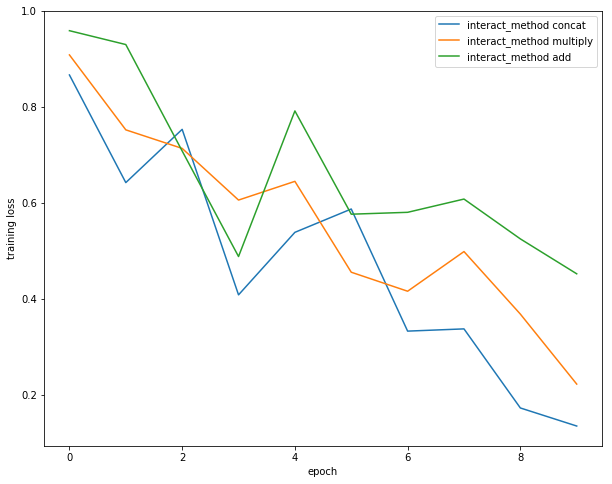

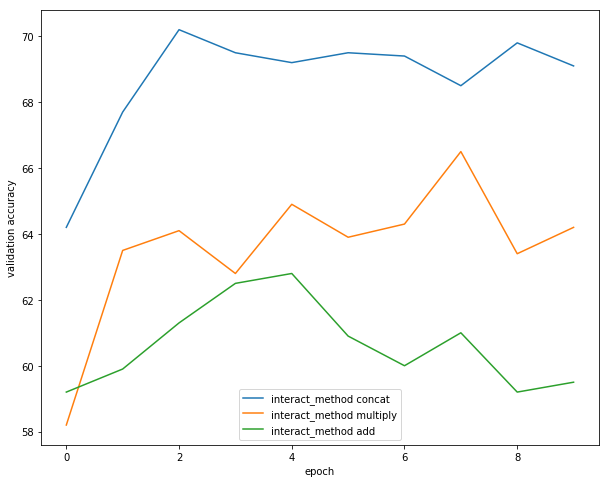

In [560]:
plt.figure()
for i in range(len(train_loss_methods)):
    plt.plot(range(10),train_loss_methods[i], label='interact_method %s' %interact_methods[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_methods)):
    plt.plot(range(10),val_acc_methods[i], label='interact_method %s' %interact_methods[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')

In [473]:
from torch.autograd import Variable
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, hidden_size_fc, interact_method):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix), freeze=True)
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.interact_method = interact_method
        if self.interact_method == 'concat':
            input_hidden_size = hidden_size*2
        else:
            input_hidden_size = hidden_size
        self.fc = nn.Sequential(nn.Linear(input_hidden_size, hidden_size_fc), nn.ReLU(inplace=True),
                                nn.Linear(hidden_size_fc,num_classes))


    def forward(self, x_0, lengths_0, x_1, lengths_1):
        # get embedding
        embed_0 = self.embedding(x_0)
        
        #sort
        _, idx_sort_0 = torch.sort(lengths_0, dim=0, descending=True)
        _, idx_unsort_0 = torch.sort(idx_sort_0, dim=0)
        lengths_0 = list(lengths_0[idx_sort_0])
        idx_sort_0 = Variable(idx_sort_0)
        idx_unsort_0 = Variable(idx_unsort_0)
        # Sort input
        embed_0 = embed_0.index_select(0, idx_sort_0)
        # Transpose batch and sequence dims
        embed_0 = embed_0.transpose(0, 1)
        # Pack it up
        rnn_input_0 = nn.utils.rnn.pack_padded_sequence(embed_0, lengths_0)
        # Encode
        _, hidden_output_0 = self.gru(rnn_input_0)
        hidden_output_0 = hidden_output_0.permute(1,0,2).sum(dim=1)
        
        # Do the same to sentence2
        embed_1 = self.embedding(x_1)
        _, idx_sort_1 = torch.sort(lengths_1, dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        lengths_1 = list(lengths_1[idx_sort_1])
        idx_sort_1 = Variable(idx_sort_1)
        idx_unsort_1 = Variable(idx_unsort_1)
        embed_1 = embed_1.index_select(0, idx_sort_1)
        embed_1 = embed_1.transpose(0, 1)
        rnn_input_1 = nn.utils.rnn.pack_padded_sequence(embed_1, lengths_1)
        _, hidden_output_1 = self.gru(rnn_input_1)
        hidden_output_1 = hidden_output_1.permute(1,0,2).sum(dim=1)
        
        # Unsort
        hidden_output_0 = hidden_output_0.index_select(0,idx_unsort_0)
        hidden_output_1 = hidden_output_1.index_select(0,idx_unsort_1)
        
        #concat two sentence representations
        if self.interact_method == 'concat':
            combined_vector = torch.cat([hidden_output_0, hidden_output_1], dim=1)
        elif self.interact_method == 'multiply':
            combined_vector = torch.mul(hidden_output_0,hidden_output_1)
        elif self.interact_method == 'add':
            combined_vector = hidden_output_0 + hidden_output_1
        output = self.fc(combined_vector)
        
        return output


In [474]:
def train_model_RNN(emb_size = 300, learning_rate = 0.001, annealing_rate = 0, step = 1, hidden_size=200, hidden_size_fc=200,
                num_epochs = 5, num_classes=3, optim = 'Adam', interact_method='concat'):
    """
    Help function that tests the model's performance on a dataset
    @param: emb_dim - embedding size
            vocab_size - vocabulary size
            learning_rate - learning rate of the optimizer, if annealing_rate is not 0, this is a start learning
                rate
            annealing_rate - a factor that shrinks the learning rate every step size
            step - step size (epochs)
            optim - optimizer, can choose from 'Adam' or 'SGD'
            
    """
    model = RNN(emb_size=emb_size, hidden_size=hidden_size, num_layers=1, num_classes=num_classes, 
                hidden_size_fc=hidden_size, interact_method=interact_method).double()
    criterion = torch.nn.CrossEntropyLoss()  
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # set the scheduler for learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=annealing_rate)
    epoch_train_loss = []
    epoch_val_acc = []
    for epoch in range(num_epochs):
        # only decay the learning rate when annealing rate is given
        if annealing_rate!=0:
            scheduler.step()
        for i, (data_0, lengths_0, data_1, lengths_1, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data_0, lengths_0, data_1, lengths_1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
                
        epoch_train_loss.append(loss.item())
        val_acc = test_model(val_loader, model)
        print('Epoch: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, val_acc))
        epoch_val_acc.append(val_acc)
    return epoch_train_loss, epoch_val_acc, model

## Tuning hyperparameters for RNN

### hidden dimension

In [478]:
hidden_sizes = [50, 200, 400]
train_loss_hiddens = []
val_acc_hiddens = []
for hidden_size in hidden_sizes:
    train_loss_hidden, val_acc_hidden, _ = train_model_RNN(emb_size = 300, hidden_size=hidden_size, 
                        hidden_size_fc=hidden_size ,num_classes=3, learning_rate = 0.001, num_epochs = 5)
    train_loss_hiddens.append(train_loss_hidden)
    val_acc_hiddens.append(val_acc_hidden)
        

Epoch: [1/5], Validation Acc: 64.7
Epoch: [2/5], Validation Acc: 66.9
Epoch: [3/5], Validation Acc: 70.1
Epoch: [4/5], Validation Acc: 71.9
Epoch: [5/5], Validation Acc: 71.6
Epoch: [1/5], Validation Acc: 68.0
Epoch: [2/5], Validation Acc: 67.7
Epoch: [3/5], Validation Acc: 70.7
Epoch: [4/5], Validation Acc: 72.8
Epoch: [5/5], Validation Acc: 72.0
Epoch: [1/5], Validation Acc: 67.4
Epoch: [2/5], Validation Acc: 72.2
Epoch: [3/5], Validation Acc: 72.1
Epoch: [4/5], Validation Acc: 72.0
Epoch: [5/5], Validation Acc: 72.2


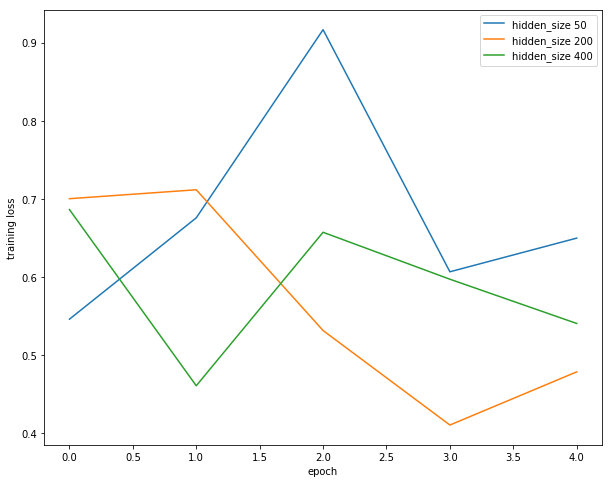

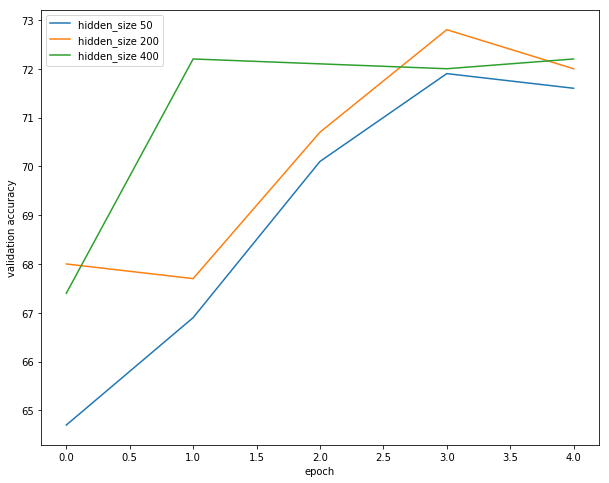

In [479]:
plt.figure()
for i in range(len(train_loss_hiddens)):
    plt.plot(range(5),train_loss_hiddens[i], label='hidden_size %d' %hidden_sizes[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_hiddens)):
    plt.plot(range(5),val_acc_hiddens[i], label='hidden_size %d' %hidden_sizes[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')

### sentence interaction

In [480]:
interact_methods = ['concat', 'multiply', 'add']
train_loss_methods = []
val_acc_methods = []
for interact_method in interact_methods:
    train_loss_method, val_acc_method, _ = train_model_RNN(emb_size = 300, hidden_size=200, interact_method=interact_method,
                        hidden_size_fc=200 ,num_classes=3, learning_rate = 0.001, num_epochs = 5)
    train_loss_methods.append(train_loss_method)
    val_acc_methods.append(val_acc_method)
    

Epoch: [1/5], Validation Acc: 68.4
Epoch: [2/5], Validation Acc: 70.3
Epoch: [3/5], Validation Acc: 72.9
Epoch: [4/5], Validation Acc: 73.2
Epoch: [5/5], Validation Acc: 73.6
Epoch: [1/5], Validation Acc: 67.8
Epoch: [2/5], Validation Acc: 69.4
Epoch: [3/5], Validation Acc: 71.1
Epoch: [4/5], Validation Acc: 72.0
Epoch: [5/5], Validation Acc: 70.5
Epoch: [1/5], Validation Acc: 61.8
Epoch: [2/5], Validation Acc: 61.5
Epoch: [3/5], Validation Acc: 63.4
Epoch: [4/5], Validation Acc: 64.9
Epoch: [5/5], Validation Acc: 67.6


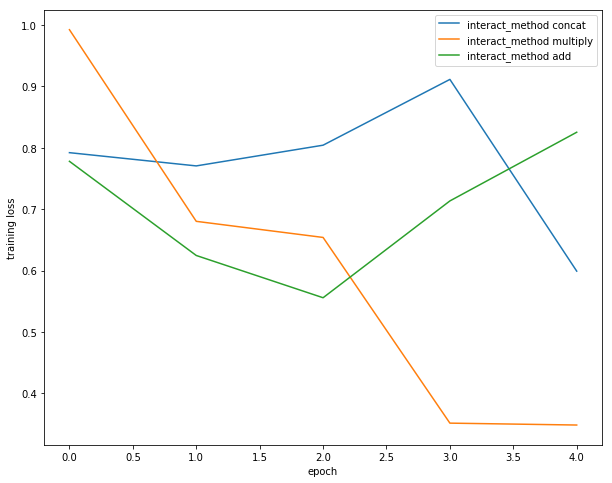

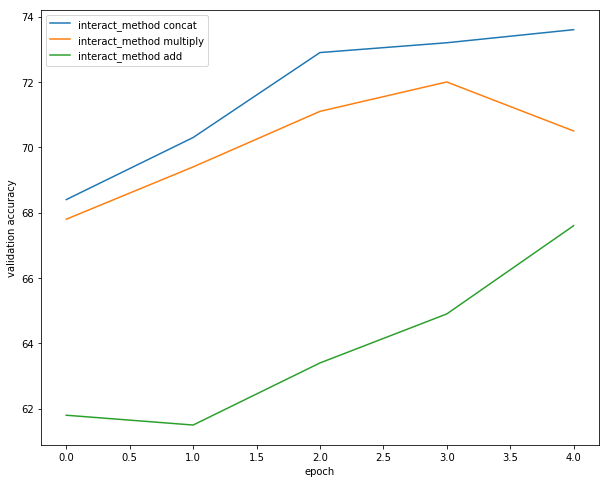

In [482]:
plt.figure()
for i in range(len(train_loss_methods)):
    plt.plot(range(5),train_loss_methods[i], label='interact_method %s' %interact_methods[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_methods)):
    plt.plot(range(5),val_acc_methods[i], label='interact_method %s' %interact_methods[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')

# Train best model and report results

In [484]:
train_loss_cnn, val_acc_cnn, model_cnn = train_model_CNN(emb_size = 300, hidden_size=200, 
                        hidden_size_fc=200 ,num_classes=3, learning_rate = 0.001, num_epochs = 10, kernel_size=5)

Epoch: [1/10], Validation Acc: 63.5
Epoch: [2/10], Validation Acc: 68.9
Epoch: [3/10], Validation Acc: 69.5
Epoch: [4/10], Validation Acc: 68.2
Epoch: [5/10], Validation Acc: 69.9
Epoch: [6/10], Validation Acc: 70.1
Epoch: [7/10], Validation Acc: 69.3
Epoch: [8/10], Validation Acc: 69.6
Epoch: [9/10], Validation Acc: 69.1
Epoch: [10/10], Validation Acc: 69.7


In [485]:
print("After 10 epochs")
print("The validation accuracy of the best CNN model is {}".format(val_acc_cnn[-1]))

After 10 epochs
The validation accuracy of the best CNN model is 69.7


In [486]:
train_loss_rnn, val_acc_rnn, model_rnn = train_model_RNN(emb_size = 300, hidden_size=400, interact_method='concat',
                        hidden_size_fc=400 ,num_classes=3, learning_rate = 0.001, num_epochs = 10)

Epoch: [1/5], Validation Acc: 67.2
Epoch: [2/5], Validation Acc: 72.1
Epoch: [3/5], Validation Acc: 73.2
Epoch: [4/5], Validation Acc: 73.8
Epoch: [5/5], Validation Acc: 73.8


In [488]:
print("After 5 epochs")
print("The validation accuracy of the best RNN model is {}".format(val_acc_rnn[-1]))

After 5 epochs
The validation accuracy of the best RNN model is 73.8


In [494]:
def find_example_index():
    wrong_indices = {}
    correct_indices = []
    n_loop = 0
    for data_0, lengths_0, data_1, lengths_1, labels in val_loader:
        outputs = F.softmax(model_rnn(data_0, lengths_0, data_1, lengths_1), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        wrong = predicted.eq(labels.view_as(predicted))==0
        correct = predicted.eq(labels.view_as(predicted))==1
        wrong_indices_current = np.where(np.array(wrong).ravel())[0].tolist()
        correct_indices_current = np.where(np.array(correct).ravel())[0].tolist()
        for index in wrong_indices_current:
            wrong_indices[index+32*n_loop] = predicted[index]
#        wrong_indices.extend([index + 32*n_loop for index in wrong_indices_current])
        correct_indices.extend([index + 32*n_loop for index in correct_indices_current])
        n_loop += 1
    return wrong_indices, correct_indices
        


In [515]:
import random
labels_dict = {0:'contradiction', 1:'neutral', 2:'entailment'}
wrong_indices, correct_indices = find_example_index()


In [516]:
print("Three incorrect examples\n")
for index in random.sample(wrong_indices.keys(),3):
    print("Premise: {}. \n Hypothesis: {}. \n It is originally labeled as:{}, we predict it as:{}".
          format(validation[0][index], validation[1][index],
          labels_dict[validation[2][index].item()], labels_dict[wrong_indices[index].item()]))
    print('\n')

Three incorrect examples

Premise: Black man singing with microphone. 
 Hypothesis: This is a singer. 
 It is originally labeled as:entailment, we predict it as:neutral


Premise: A man bakes in a kitchen while wearing gloves and a hat .. 
 Hypothesis: The man is baking a cake .. 
 It is originally labeled as:neutral, we predict it as:contradiction


Premise: A lone , 2-3 year old blond child in a blue jacket is putting a small black plastic item in his mouth as he kneels on a waiting room couch pointed toward the back while looking at something or someone not in the room .. 
 Hypothesis: The child is blonde .. 
 It is originally labeled as:entailment, we predict it as:neutral




In [512]:
print("Three correct examples\n")
for index in random.sample(correct_indices,3):
    print("Premise: {}. \n Hypothesis: {}. ".format(validation[0][index], validation[1][index]))
    print('\n')


Three correct examples

Premise: Two girls are in line about to order at a Mexican eatery .. 
 Hypothesis: Two sad girls are in line about to order at a Mexican eatery .. 


Premise: Two kids standing beside a snowman .. 
 Hypothesis: Two children lie by a pool in summer .. 


Premise: Three people in t-shirt , yellow helmets and harnesses begin to climb ladder .. 
 Hypothesis: Three people walk up the stairs .. 




# Evaluate on MultiNLI

In [537]:
def load_MultiNLI(filename, genre_type):
    left = []
    right = []
    labels = []
    labels_dict = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    genres = []
    with open(filename, ) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        next(reader)
        for line in reader:
            s1, s2, label, genre = line
            if genre != genre_type:
                continue
            left.append(s1)
            right.append(s2)
            labels.append(label)
            genres.append(genre)
    print('the maximum length for premise is:{}'.format(max(len(x.split()) for x in left)))
    print('the maximum length for hypothesis is:{}'.format(max(len(x.split()) for x in right)))
    print (set(genres))
    Y = np.array([labels_dict[l] for l in labels]) 
    return left, right, Y

#### telephone

In [561]:
validation_tel = load_MultiNLI('hw2_data/mnli_val.tsv', 'telephone')
val_indices_tel= token2index_dataset(validation_tel[0]), token2index_dataset(validation_tel[1])
# double checking
print ("Val dataset size is {}".format(len(val_indices_tel[0])))
val_dataset_tel = NewsGroupDataset(val_indices_tel, validation_tel[2])
val_loader_tel = torch.utils.data.DataLoader(dataset=val_dataset_tel, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

the maximum length for premise is:205
the maximum length for hypothesis is:39
{'telephone'}
Val dataset size is 1005


In [562]:
#cnn
print(test_model(val_loader_tel, model_cnn))
#rnn
print(test_model(val_loader_tel, model_rnn))

41.592039800995025
47.06467661691542


#### fiction

In [563]:
validation_fic = load_MultiNLI('hw2_data/mnli_val.tsv', 'fiction')
val_indices_fic= token2index_dataset(validation_fic[0]), token2index_dataset(validation_fic[1])
# double checking
print ("Val dataset size is {}".format(len(val_indices_fic[0])))
val_dataset_fic = NewsGroupDataset(val_indices_fic, validation_fic[2])
val_loader_fic = torch.utils.data.DataLoader(dataset=val_dataset_fic, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

the maximum length for premise is:12491
the maximum length for hypothesis is:43
{'fiction'}
Val dataset size is 995


In [564]:
#cnn
print(test_model(val_loader_fic, model_cnn))
#rnn
print(test_model(val_loader_fic, model_rnn))

45.62814070351759
48.34170854271357


#### government

In [570]:
validation_gov = load_MultiNLI('hw2_data/mnli_val.tsv', 'government')
val_indices_gov= token2index_dataset(validation_gov[0]), token2index_dataset(validation_gov[1])
# double checking
print ("Val dataset size is {}".format(len(val_indices_gov[0])))
val_dataset_gov = NewsGroupDataset(val_indices_gov, validation_gov[2])
val_loader_gov = torch.utils.data.DataLoader(dataset=val_dataset_gov, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

the maximum length for premise is:115
the maximum length for hypothesis is:51
{'government'}
Val dataset size is 1016


In [571]:
#cnn
print(test_model(val_loader_gov, model_cnn))
#rnn
print(test_model(val_loader_gov, model_rnn))

41.830708661417326
46.75196850393701


#### slate

In [572]:
validation_sla = load_MultiNLI('hw2_data/mnli_val.tsv', 'slate')
val_indices_sla= token2index_dataset(validation_sla[0]), token2index_dataset(validation_sla[1])
# double checking
print ("Val dataset size is {}".format(len(val_indices_sla[0])))
val_dataset_sla = NewsGroupDataset(val_indices_sla, validation_sla[2])
val_loader_sla = torch.utils.data.DataLoader(dataset=val_dataset_sla, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

the maximum length for premise is:113
the maximum length for hypothesis is:37
{'slate'}
Val dataset size is 1002


In [573]:
#cnn
print(test_model(val_loader_sla, model_cnn))
#rnn
print(test_model(val_loader_sla, model_rnn))

41.616766467065865
45.908183632734534


#### travel

In [574]:
validation_tra = load_MultiNLI('hw2_data/mnli_val.tsv', 'travel')
val_indices_tra= token2index_dataset(validation_tra[0]), token2index_dataset(validation_tra[1])
# double checking
print ("Val dataset size is {}".format(len(val_indices_tra[0])))
val_dataset_tra = NewsGroupDataset(val_indices_tra, validation_tra[2])
val_loader_tra = torch.utils.data.DataLoader(dataset=val_dataset_tra, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

the maximum length for premise is:85
the maximum length for hypothesis is:38
{'travel'}
Val dataset size is 982


In [575]:
#cnn
print(test_model(val_loader_tra, model_cnn))
#rnn
print(test_model(val_loader_tra, model_rnn))

43.58452138492871
44.908350305498985
